# 1.  Wczytanie danych i wyliczenie wartosci OSNR

In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
tree = ET.parse('polska')
root = tree.getroot()

## Miasta (nodes)

In [3]:
Nodes = {}
for node in root.findall(".//{http://sndlib.zib.de/network}node"):
    x = node.find(".//{http://sndlib.zib.de/network}x")
    y = node.find(".//{http://sndlib.zib.de/network}y")
    Nodes[node.get('id')] = [float(x.text), float(y.text)]
Nodes

{'Bialystok': [23.1, 53.1],
 'Bydgoszcz': [17.9, 53.1],
 'Gdansk': [18.6, 54.2],
 'Katowice': [18.8, 50.3],
 'Kolobrzeg': [16.1, 54.2],
 'Krakow': [19.8, 50.0],
 'Lodz': [19.4, 51.7],
 'Poznan': [16.8, 52.4],
 'Rzeszow': [21.9, 50.0],
 'Szczecin': [14.5, 53.4],
 'Warsaw': [21.0, 52.2],
 'Wroclaw': [16.9, 51.1]}

## Połączenia

In [4]:
Links = {}
for link in root.findall(".//{http://sndlib.zib.de/network}link"):
    source = link.find(".//{http://sndlib.zib.de/network}source")
    target = link.find(".//{http://sndlib.zib.de/network}target")
    setupCost = link.find(".//{http://sndlib.zib.de/network}setupCost")
    
    longitudeS = Nodes[source.text][0]
    longitudeT = Nodes[target.text][0]
    latitudeS = Nodes[source.text][1]
    latitudeT = Nodes[target.text][1]
    
    #distance1 = math.sqrt((longitudeS - longitudeT)**2 + (latitudeS - latitudeT)**2) * 73
    distance2 = math.acos(math.sin(math.radians(latitudeS))*math.sin(math.radians(latitudeT)) + math.cos(math.radians(latitudeS))*
                          math.cos(math.radians(latitudeT))*math.cos(math.radians(longitudeT - longitudeS)) )* 6371
    Links[link.get('id')] = distance2
Links

{'Link_0_10': 273.8496028378416,
 'Link_0_2': 162.60232837247085,
 'Link_0_5': 320.7405710847887,
 'Link_1_10': 231.811351705841,
 'Link_1_2': 170.38471371325605,
 'Link_1_7': 107.42132232440356,
 'Link_2_9': 137.66780655303617,
 'Link_3_11': 160.6764818757195,
 'Link_3_4': 78.6728876043855,
 'Link_3_6': 161.2340071135855,
 'Link_4_10': 258.5716578236298,
 'Link_4_8': 150.09198393119996,
 'Link_5_10': 173.43699098198317,
 'Link_5_8': 354.5360257175708,
 'Link_6_10': 122.94119213432361,
 'Link_6_11': 185.80862973599406,
 'Link_7_11': 144.71718812896586,
 'Link_7_9': 190.15142627508948}

## Ścieżki wraz z OSNR

In [5]:
def addNodetoPath(node1, node2, input_list):
    if len(input_list) == 2 :
        if node1 in input_list and node1 == input_list[0] :
            #print('pierwszy przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node2)
            return input_list
        if node2 in input_list and node2 == input_list[0] :
            #print('drugi przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node1)
            return input_list  
    if node1 not in input_list : 
        input_list.append(node1)
    if node2 not in input_list : 
        input_list.append(node2)
        
    return input_list

In [6]:
n = 0
Y_values = []
input_list = []
for demand in root.findall(".//{http://sndlib.zib.de/network}demand"):
    source = demand.find(".//{http://sndlib.zib.de/network}source")
    target = demand.find(".//{http://sndlib.zib.de/network}target")
    demandValue = demand.find(".//{http://sndlib.zib.de/network}demandValue")
    #print(demand.attrib)
    print("Source: " + source.text)
    print("Target: " + target.text)
    print("DemandValue: " + demandValue.text)
    
    admissiblePaths = demand.findall(".//{http://sndlib.zib.de/network}admissiblePath")
    for path in admissiblePaths:
        path_links = path.findall(".//{http://sndlib.zib.de/network}linkId")
        values = 0;
        node_list=[]
        for link_id in path_links:
            values = values + 300./float(Links[link_id.text])
            words = link_id.text.split('_')
            node_list = addNodetoPath(words[1], words[2], node_list)
        input_list.append(node_list.copy()) 
        size = float(len(node_list))
        values= values + 300./min(Links.values())*(11-size)
        values = values + 10./(size-1)
        Y_values.append(values)
        n = n+1
        print(node_list)
        print(values)  
        node_list.clear()
"All paths: {}".format(n)

Source: Gdansk
Target: Bydgoszcz
DemandValue: 195.0
['0', '2', '1']
39.111775527610455
['0', '10', '1']
37.89570976324386
['0', '2', '9', '7', '1']
33.77412898818498
['0', '5', '10', '1']
33.98536367924393
['0', '10', '4', '3', '11', '7', '1']
29.721523571155718
['0', '2', '9', '7', '11', '3', '4', '10', '1']
24.68610440131703
['0', '5', '8', '4', '10', '1']
27.300950612745368
Source: Gdansk
Target: Kolobrzeg
DemandValue: 158.0
['0', '2']
46.16431196677906
['0', '10', '1', '2']
34.17650665740858
['0', '5', '10', '1', '2']
31.09949390674199
['0', '10', '4', '3', '11', '7', '1', '2']
27.430891893891868
['0', '10', '1', '7', '9', '2']
30.005526784649767
['0', '5', '8', '4', '10', '1', '2']
24.91508084024343
['0', '5', '10', '4', '3', '11', '7', '1', '2']
25.008641047987183
Source: Gdansk
Target: Katowice
DemandValue: 174.0
['0', '5', '8', '4', '3']
32.97309041124482
['0', '10', '4', '3']
36.09510728532111
['0', '5', '10', '4', '3']
33.018094534654516
['0', '5', '8', '4', '10', '6', '3']
2

'All paths: 462'

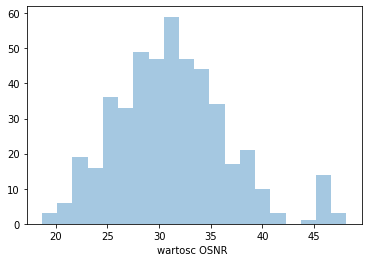

In [7]:
xs = pd.Series(Y_values,name="wartosc OSNR ")
sns.distplot(xs,bins=20, kde=False);

In [8]:
print("Min: {}".format(min(Y_values)))
print("Max: {}".format(max(Y_values)))
print("Mean: {}".format(statistics.mean(Y_values)))

Min: 18.680154700631682
Max: 48.13257770689441
Mean: 31.264953871433754


## 2. Przygotowanie danych

In [9]:
X_input = np.full((462,11), -1)
n = 0
for path in input_list:
    for i in range(len(path)):
        X_input[n][i] = path[i]
    n =n+1
X_input

array([[ 0,  2,  1, ..., -1, -1, -1],
       [ 0, 10,  1, ..., -1, -1, -1],
       [ 0,  2,  9, ..., -1, -1, -1],
       ...,
       [10,  1,  7, ..., -1, -1, -1],
       [10,  6,  3, ..., -1, -1, -1],
       [10,  4,  8, ..., 11, -1, -1]])

In [10]:
Y_output = np.array(Y_values)

delimit_values=np.quantile(Y_output, [0.25,0.5,0.75])
delimit_values

Y_output[Y_output<=delimit_values[0]]=0
Y_output[(Y_output>delimit_values[0]) & (Y_output<=delimit_values[1])]=1
Y_output[(Y_output>delimit_values[1]) & (Y_output<=delimit_values[2])]=2
Y_output[Y_output>delimit_values[2]]=3
Y_output


array([3., 3., 2., 2., 1., 0., 0., 3., 2., 2., 0., 1., 0., 0., 2., 3., 2.,
       0., 1., 3., 2., 2., 3., 2., 2., 3., 2., 1., 3., 3., 2., 1., 1., 0.,
       0., 1., 3., 3., 1., 1., 2., 2., 3., 3., 3., 0., 2., 2., 1., 3., 2.,
       2., 1., 2., 1., 0., 3., 2., 2., 1., 1., 2., 0., 3., 3., 3., 1., 1.,
       1., 0., 2., 1., 2., 1., 2., 1., 0., 3., 3., 2., 0., 2., 0., 0., 1.,
       0., 1., 1., 1., 0., 3., 1., 0., 1., 2., 1., 3., 3., 3., 1., 0., 2.,
       3., 1., 1., 0., 0., 1., 2., 1., 0., 0., 3., 3., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 3., 2., 3., 3., 0., 2., 0., 0., 0., 3., 3., 1.,
       0., 2., 2., 1., 3., 0., 0., 2., 2., 1., 0., 1., 2., 2., 1., 0., 1.,
       2., 2., 2., 2., 2., 1., 2., 2., 3., 3., 3., 1., 1., 1., 1., 1., 3.,
       3., 2., 0., 0., 2., 3., 3., 1., 2., 1., 0., 1., 2., 2., 2., 1., 1.,
       2., 2., 3., 3., 1., 0., 0., 0., 0., 3., 3., 3., 2., 1., 1., 1., 3.,
       1., 2., 3., 1., 1., 0., 3., 3., 0., 0., 1., 2., 0., 3., 3., 3., 1.,
       0., 2., 2., 3., 3.

## k-krotna walidacja

In [11]:
from sklearn.model_selection import KFold

In [12]:
kf=KFold(n_splits=20)

for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    print("Train: ", statistics.mean(Y_train), "Test: ", statistics.mean(Y_test))

Train:  1.4931506849315068 Test:  1.625
Train:  1.4817351598173516 Test:  1.8333333333333333
Train:  1.4943052391799545 Test:  1.608695652173913
Train:  1.5193621867881548 Test:  1.1304347826086956
Train:  1.5079726651480638 Test:  1.3478260869565217
Train:  1.5148063781321184 Test:  1.2173913043478262
Train:  1.4965831435079726 Test:  1.565217391304348
Train:  1.4965831435079726 Test:  1.565217391304348
Train:  1.4943052391799545 Test:  1.608695652173913
Train:  1.4920273348519362 Test:  1.6521739130434783
Train:  1.5079726651480638 Test:  1.3478260869565217
Train:  1.4783599088838268 Test:  1.9130434782608696
Train:  1.5239179954441913 Test:  1.0434782608695652
Train:  1.4760820045558087 Test:  1.9565217391304348
Train:  1.4943052391799545 Test:  1.608695652173913
Train:  1.5079726651480638 Test:  1.3478260869565217
Train:  1.5056947608200455 Test:  1.391304347826087
Train:  1.5125284738041003 Test:  1.2608695652173914
Train:  1.5056947608200455 Test:  1.391304347826087
Train:  1.496

# 3. Analiza z wykorzystaniem sztucznej sieci neuronowej

In [298]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [309]:
X_train, X_test, Y_train, Y_test = train_test_split(X_input,Y_output, test_size=0.15)

## First version

In [310]:
model = Sequential()
model.add(Dense(64, input_dim = 11, activation = 'relu'))
model.add(Dense(34, activation = 'relu'))
model.add(Dense(1, activation ='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                768       
_________________________________________________________________
dense_17 (Dense)             (None, 34)                2210      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 35        
Total params: 3,013
Trainable params: 3,013
Non-trainable params: 0
_________________________________________________________________
None


In [311]:
epochs = 150
batch_size = 10
callback_early_stopping =EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

In [312]:
history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 1, 
         callbacks = [callback_early_stopping])

Train on 333 samples, validate on 59 samples
Epoch 1/150
333/333 [==============================] - 1s 4ms/step - loss: 0.4232 - accuracy: 0.8108 - val_loss: 0.2417 - val_accuracy: 0.9322
Epoch 2/150
333/333 [==============================] - 0s 569us/step - loss: 0.1772 - accuracy: 0.9369 - val_loss: 0.1676 - val_accuracy: 0.9322
Epoch 3/150
333/333 [==============================] - 0s 675us/step - loss: 0.1276 - accuracy: 0.9550 - val_loss: 0.1437 - val_accuracy: 0.9322
Epoch 4/150
333/333 [==============================] - 0s 753us/step - loss: 0.1121 - accuracy: 0.9520 - val_loss: 0.1418 - val_accuracy: 0.9322
Epoch 5/150
333/333 [==============================] - 0s 638us/step - loss: 0.1000 - accuracy: 0.9580 - val_loss: 0.1332 - val_accuracy: 0.9492
Epoch 6/150
333/333 [==============================] - 0s 510us/step - loss: 0.0912 - accuracy: 0.9580 - val_loss: 0.1307 - val_accuracy: 0.9492
Epoch 7/150
333/333 [==============================] - 0s 588us/step - loss: 0.0865 - a

In [313]:
y_test,accuracy = model.evaluate(X_test, Y_test)

70/70 [==============================] - 0s 132us/step


In [314]:
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 92.86


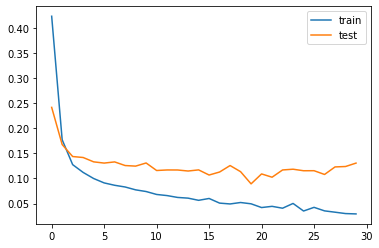

In [315]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

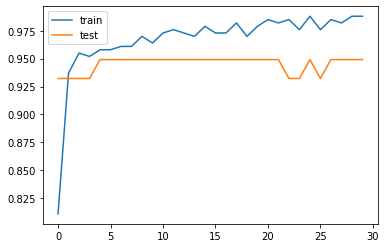

In [316]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Second version - three classes

In [323]:
Y_output = np.zeros((462,3))
delimit_value1 = 22
delimit_value2 = 35

Categorize output into three classes - first x < delimit1, second x (delimit1, delimit2), third x>delimit2

In [325]:
for i in range(Y_output.shape[0]):
    if Y_output_s[i] > delimit_value2 : Y_output[i][2] = 1
    elif Y_output_s[i] < delimit_value1 : Y_output[i][0] = 1
    else : Y_output[i][1] = 1

In [326]:
Y_output

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [327]:
X_train, X_test, Y_train, Y_test = train_test_split(X_input,Y_output, test_size=0.15)

In [329]:
model = Sequential()
model.add(Dense(64, input_dim = 11, activation = 'relu'))
model.add(Dense(34, activation = 'relu'))
model.add(Dense(3, activation ='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                768       
_________________________________________________________________
dense_23 (Dense)             (None, 34)                2210      
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 105       
Total params: 3,083
Trainable params: 3,083
Non-trainable params: 0
_________________________________________________________________
None


In [336]:
epochs = 150
batch_size = 10
callback_early_stopping =EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')

In [337]:
history = model.fit(X_train, Y_train, batch_size = 10, epochs = 150, validation_split= 0.15, verbose = 1, 
         callbacks = [callback_early_stopping])

Train on 333 samples, validate on 59 samples
Epoch 1/150
333/333 [==============================] - 0s 522us/step - loss: 0.1748 - accuracy: 0.9219 - val_loss: 0.2583 - val_accuracy: 0.9153
Epoch 2/150
333/333 [==============================] - 0s 610us/step - loss: 0.1706 - accuracy: 0.9279 - val_loss: 0.2822 - val_accuracy: 0.8983
Epoch 3/150
333/333 [==============================] - 0s 514us/step - loss: 0.1661 - accuracy: 0.9219 - val_loss: 0.2511 - val_accuracy: 0.9153
Epoch 4/150
333/333 [==============================] - 0s 471us/step - loss: 0.1589 - accuracy: 0.9339 - val_loss: 0.2668 - val_accuracy: 0.9153
Epoch 5/150
333/333 [==============================] - 0s 506us/step - loss: 0.1519 - accuracy: 0.9339 - val_loss: 0.2718 - val_accuracy: 0.9153
Epoch 6/150
333/333 [==============================] - 0s 517us/step - loss: 0.1478 - accuracy: 0.9399 - val_loss: 0.2978 - val_accuracy: 0.8983
Epoch 7/150
333/333 [==============================] - 0s 482us/step - loss: 0.1425 -

Epoch 57/150
333/333 [==============================] - 0s 599us/step - loss: 0.0741 - accuracy: 0.9670 - val_loss: 0.4344 - val_accuracy: 0.8644
Epoch 58/150
333/333 [==============================] - 0s 363us/step - loss: 0.0509 - accuracy: 0.9880 - val_loss: 0.4368 - val_accuracy: 0.8644
Epoch 59/150
333/333 [==============================] - 0s 475us/step - loss: 0.0490 - accuracy: 0.9820 - val_loss: 0.4357 - val_accuracy: 0.8644
Epoch 60/150
333/333 [==============================] - 0s 478us/step - loss: 0.0466 - accuracy: 0.9880 - val_loss: 0.4808 - val_accuracy: 0.8814
Epoch 61/150
333/333 [==============================] - 0s 470us/step - loss: 0.0774 - accuracy: 0.9670 - val_loss: 0.4341 - val_accuracy: 0.8644
Epoch 62/150
333/333 [==============================] - 0s 479us/step - loss: 0.0538 - accuracy: 0.9880 - val_loss: 0.4093 - val_accuracy: 0.8814
Epoch 63/150
333/333 [==============================] - 0s 502us/step - loss: 0.0442 - accuracy: 0.9910 - val_loss: 0.4344 -

In [338]:
loss,accuracy = model.evaluate(X_test, Y_test)

70/70 [==============================] - 0s 133us/step


In [339]:
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 85.71


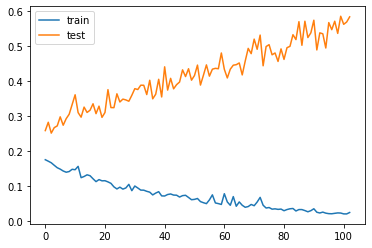

In [340]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

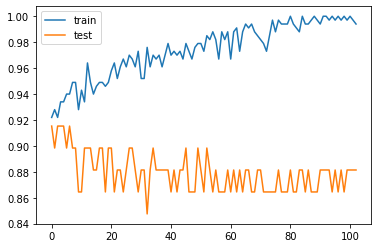

In [341]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# 4. Analiza z wykorzystaniem lasu losowego

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

## Domyslne wartosci parametrow 

In [ ]:
kf=KFold(n_splits=20)
#kf.get_n_splits(X_input)
accuracy=[]
for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    n_B=int(math.sqrt(len(X_train)))
    rf = RandomForestRegressor(n_estimators = n_B, max_samples=n_B, max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    error= predictions==Y_test
    accuracy.append(np.sum(error)/len(error))
print("Accuracy of the model: ",statistics.mean(accuracy))

## Liczba drzew

In [ ]:
n_B=int(math.sqrt(len(X_train)*19/20))
n_B

In [ ]:
B_values=[]
acc_values1=[]
n_B=int(math.sqrt(len(X_train)*19/20))

for n in range(int(math.sqrt(n_B)),15*n_B, 2):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators = n,max_depth=11, max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values1.append(statistics.mean(accuracy))
    B_values.append(n)

In [ ]:
plot(B_values,acc_values1)
plt.ylabel("Precyzja")
plt.xlabel("Liczba drzew")

In [ ]:
best_treeN=[x for (x,y) in zip(B_values,acc_values1) if y==max(acc_values1)][0]
print("Number of trees: ", best_treeN, "Accuracy: ", max(acc_values1))

## Maksymalna glebokosc drzewa

In [ ]:
Depth_values=[]
acc_values2=[]

for n in range(1,12):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators =best_treeN, max_depth=n, max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values2.append(statistics.mean(accuracy))
    Depth_values.append(n)


In [ ]:
plot(Depth_values,acc_values2)
plt.ylabel("Precyzja")
plt.xlabel("Głębokość drzew")

In [ ]:
best_depth=[x for (x,y) in zip(Depth_values,acc_values2) if y==max(acc_values2)][0]
print("Max Depth of tree: ", best_depth, "Accuracy: ", max(acc_values2))

## Liczba obiektów użyta do budowy każdego z drzew

In [ ]:
B1_values=[]
acc_values3=[]

for n in range(int(math.sqrt(n_B)),300,2):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators =best_treeN, max_depth=best_depth, max_samples=n, bootstrap=True,max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values3.append(statistics.mean(accuracy))
    B1_values.append(n)

In [ ]:
plot(B1_values,acc_values3)
plt.ylabel("Precyzja")
plt.xlabel("Liczba obiektów użyta do budowy każdego z drzew")

In [ ]:
best_bootstrap=[x for (x,y) in zip(B1_values,acc_values3) if y>0.8][0]
print("Liczba obiektow:", best_bootstrap, "precyzja: ", max(acc_values3))

## Ostateczny model

In [ ]:
accuracy=[]
for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    n_B=int(math.sqrt(len(X_train)))
    rf = RandomForestRegressor(n_estimators = best_treeN, max_depth=best_depth, max_samples=best_bootstrap,bootstrap=True, max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    error= predictions==Y_test
    accuracy.append(np.sum(error)/len(error))
#print(accuracy)
print("Accuracy of the model: ",round(statistics.mean(accuracy),4))

## Dokladana analiza polenianych bledow

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_input,Y_output, test_size=0.2)

rf = RandomForestRegressor(n_estimators = best_treeN, max_depth=best_depth, max_samples=best_bootstrap,bootstrap=True, max_features="auto", random_state = 42)
rf.fit(X_train, Y_train);
predictions = rf.predict(X_test)
predictions=np.round(predictions,0)
error= predictions==Y_test
print(np.sum(error)/len(error))

In [ ]:
print('Confusion Matrix for Random Forest')
cm=confusion_matrix(Y_test, predictions)
print(cm)
labels=[0,1,2,3]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.title('Confusion matrix for random forest')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()